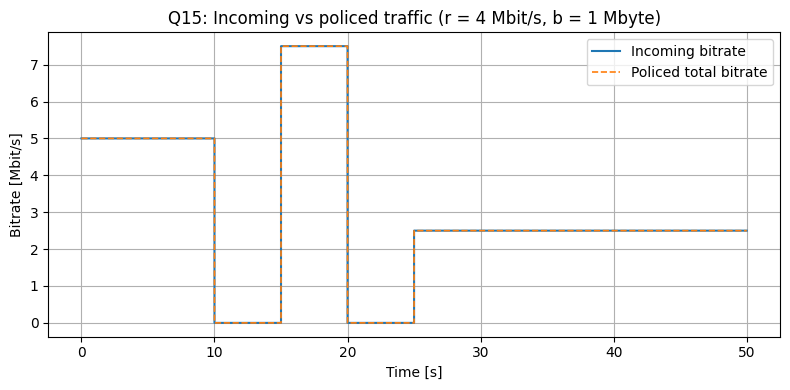

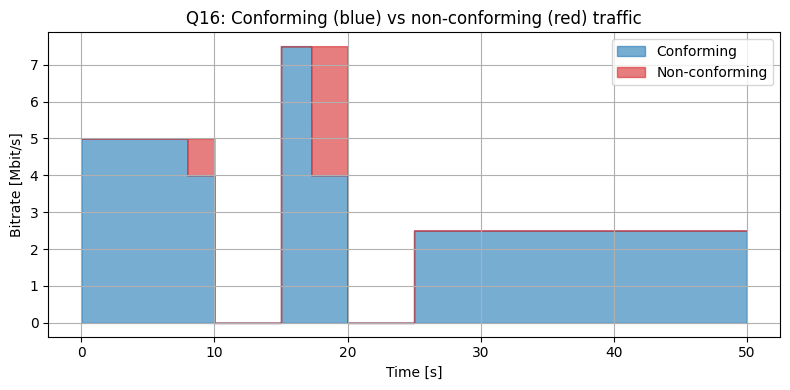

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# 1. Time grid
# --------------------------
t_end = 50.0         # seconds
dt = 0.01            # time step
t = np.arange(0, t_end + dt, dt)

# --------------------------
# 2. Incoming bitrate R_in(t)  [Mbit/s]
#    Read from Fig. 3:
#    0–10s: 5, 10–15s: 0, 15–20s: 7.5, 20–25s: 0, 25–50s: 2.5
# --------------------------
def incoming_rate(time):
    if time < 10:
        return 5.0
    elif time < 15:
        return 0.0
    elif time < 20:
        return 7.5
    elif time < 25:
        return 0.0
    else:
        return 2.5

R_in = np.array([incoming_rate(ti) for ti in t])

# --------------------------
# 3. Token bucket policer
#    r = 4 Mbit/s, b = 1 Mbyte = 8 Mbit
#    We track conforming vs non-conforming bits
# --------------------------
r = 4.0          # token generation rate [Mbit/s]
b = 8.0          # bucket size [Mbit] (1 Mbyte)
T = b            # start with full bucket

tokens     = np.zeros_like(t)  # bucket content [Mbit]
R_conf     = np.zeros_like(t)  # conforming bitrate [Mbit/s]
R_nonconf  = np.zeros_like(t)  # non-conforming bitrate [Mbit/s]

for i, ti in enumerate(t):
    Rin = R_in[i]

    # refill tokens at rate r, cap at b
    T = min(b, T + r * dt)

    incoming_bits = Rin * dt

    # conforming bits are limited by available tokens
    conf_bits = min(T, incoming_bits)
    R_conf[i] = conf_bits / dt

    # remaining bits in this step are non-conforming
    nonconf_bits = incoming_bits - conf_bits
    R_nonconf[i] = nonconf_bits / dt

    # spend tokens
    T -= conf_bits
    tokens[i] = T

# total bitrate after policing (should equal R_in)
R_policed_total = R_conf + R_nonconf

# --------------------------
# 4. Q15: bitrate of policed traffic over time
#     (total after policing = still R_in)
# --------------------------
plt.figure(figsize=(8, 4))
plt.step(t, R_in, where="post", label="Incoming bitrate", linewidth=1.5)
plt.step(t, R_policed_total, where="post",
         linestyle="--", label="Policed total bitrate", linewidth=1.2)
plt.xlabel("Time [s]")
plt.ylabel("Bitrate [Mbit/s]")
plt.title("Q15: Incoming vs policed traffic (r = 4 Mbit/s, b = 1 Mbyte)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------
# 5. Q16: two-coloured graph (blue conforming, red non-conforming)
# --------------------------
plt.figure(figsize=(8, 4))
# blue area: conforming traffic
plt.fill_between(t, 0, R_conf, step="post",
                 color="tab:blue", alpha=0.6, label="Conforming")
# red area: non-conforming traffic (stacked on top)
plt.fill_between(t, R_conf, R_conf + R_nonconf, step="post",
                 color="tab:red", alpha=0.6, label="Non-conforming")

plt.xlabel("Time [s]")
plt.ylabel("Bitrate [Mbit/s]")
plt.title("Q16: Conforming (blue) vs non-conforming (red) traffic")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


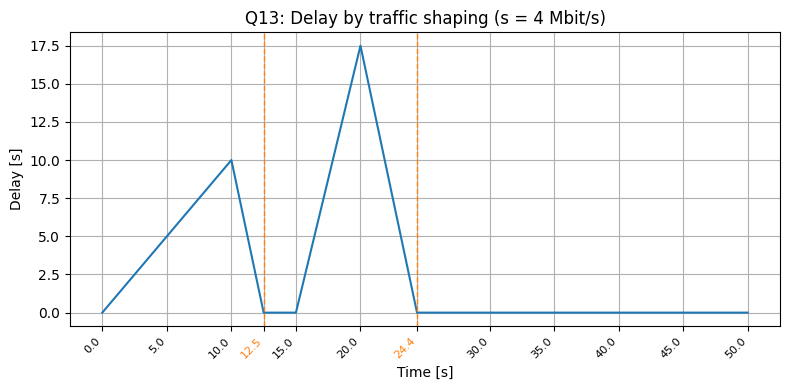

In [15]:
### Question 13 

s = 4.0  

# blocks where incoming traffic > shaping rate
blocks = [
    (0.0, 10.0, 5.0),
    (15.0, 20.0, 7.5),
]

D = np.zeros_like(t)

for (t0, t1, peak_rate) in blocks:
    increase_rate = peak_rate - s
    peak_delay = (t1 - t0) * increase_rate
    t_end_decrease = t1 + peak_delay / s

    inc_mask = (t >= t0) & (t <= t1)
    D[inc_mask] = increase_rate * (t[inc_mask] - t0)

    dec_mask = (t > t1) & (t <= t_end_decrease)
    D[dec_mask] = peak_delay - s * (t[dec_mask] - t1)

plt.figure(figsize=(8, 4))
plt.plot(t, D, linewidth=1.5)
plt.xlabel("Time [s]")
plt.ylabel("Delay [s]")
plt.title("Q13: Delay by traffic shaping (s = 4 Mbit/s)")
plt.grid(True)

# x labels
xticks = [0, 5, 10, 12.5, 15, 20, 24.375, 30, 35, 40, 45, 50]
xtick_labels = ["0.0", "5.0", "10.0", "12.5", "15.0",
                "20.0", "24.4", "30.0", "35.0", "40.0", "45.0", "50.0"]
plt.xticks(xticks, xtick_labels, rotation=45, ha="right", fontsize=8)

special_labels = {"12.5",  "24.4"}
ax = plt.gca()
for tick in ax.get_xticklabels():
    if tick.get_text() in special_labels:
        tick.set_color("tab:orange")


special_times = [12.5, 24.375]
for x in special_times:
    plt.axvline(x=x, color="tab:orange", linestyle="--", linewidth=1.0)

plt.tight_layout()
plt.show()





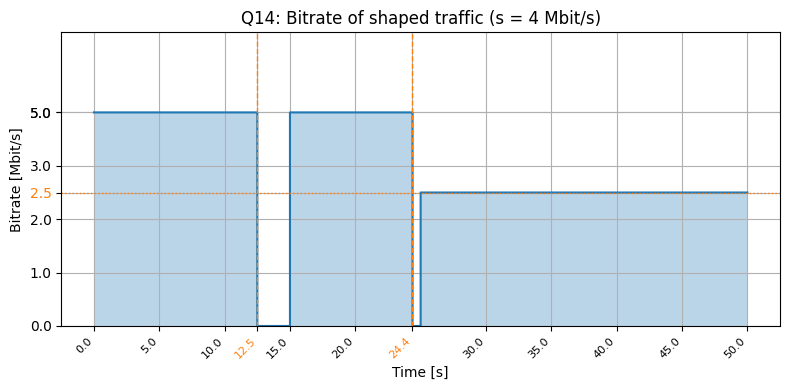

In [ ]:
### Question 14

def shaped_rate(time):
    # top at shaping rate
    if 0 <= time < 12.5:
        return 4.0
    # no backlog
    elif 12.5 <= time < 15:
        return 0.0
    # top at shaping rate
    elif 15 <= time < 24.375:
        return 4.0
    # no backlog
    elif 24.375 <= time < 25:
        return 0.0
    # input as normal
    elif 25 <= time <= 50:
        return 2.5
    else:
        return 0.0

R_shaped = np.array([shaped_rate(ti) for ti in t])

plt.figure(figsize=(8, 4))

# Filled blocks for shaped bitrate
plt.fill_between(t, 0, R_shaped, step="post", alpha=0.3)

# Outline on top for clarity
plt.step(t, R_shaped, where="post", linewidth=1.5)

plt.xlabel("Time [s]")
plt.ylabel("Bitrate [Mbit/s]")
plt.title("Q14: Bitrate of shaped traffic (s = 4 Mbit/s)")
plt.grid(True)


xticks = [0, 5, 10, 12.5, 15, 20, 24.375, 30, 35, 40, 45, 50]
xtick_labels = ["0.0", "5.0", "10.0", "12.5", "15.0",
                "20.0", "24.4", "30.0", "35.0", "40.0", "45.0", "50.0"]
plt.xticks(xticks, xtick_labels, rotation=45, ha="right", fontsize=8)

# Color the special tick labels in orange
special_labels = {"12.5", "24.4"}
ax = plt.gca()
for tick in ax.get_xticklabels():
    if tick.get_text() in special_labels:
        tick.set_color("tab:orange")


special_times = [12.5, 24.375]
for x in special_times:
    plt.axvline(x=x, color="tab:orange", linestyle="--", linewidth=1.0)


yticks = [0.0, 1.0, 2.0, 2.5, 3.0, 4.0, 4.0]
ytick_labels = ["0.0", "1.0", "2.0", "2.5", "3.0", "4.0", "5.0"]
plt.yticks(yticks, ytick_labels)

special_ylabels = {"2.5"}
for tick in ax.get_yticklabels():
    if tick.get_text() in special_ylabels:
        tick.set_color("tab:orange")


plt.axhline(y=2.5, color="tab:orange", linestyle=":", linewidth=1.0)

plt.ylim(0, 5.5)
plt.tight_layout()
plt.show()
